Analysis / Problem Statement: 

Each row in the dataset represents a single client’s profile, including demographic information and six months of payment history (April–September 2005). The target variable indicates whether the client defaulted on their credit card payment in October 2005 (the following month).

The objective of this project is to build a model that can predict the likelihood of default in the next month based on a client’s profile and historical repayment behavior.

In [24]:
#Import Data
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
import xgboost as xgb
from xgboost import XGBClassifier
import joblib

In [25]:
data=pd.read_csv("/Users/alyssafroment/Desktop/Relevant Projects/Post Grad Personal Projects/Credit Risk/UCI_Credit_Card.csv")
data

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000.0,1,3,1,39,0,0,0,0,...,88004.0,31237.0,15980.0,8500.0,20000.0,5003.0,3047.0,5000.0,1000.0,0
29996,29997,150000.0,1,3,2,43,-1,-1,-1,-1,...,8979.0,5190.0,0.0,1837.0,3526.0,8998.0,129.0,0.0,0.0,0
29997,29998,30000.0,1,2,2,37,4,3,2,-1,...,20878.0,20582.0,19357.0,0.0,0.0,22000.0,4200.0,2000.0,3100.0,1
29998,29999,80000.0,1,3,1,41,1,-1,0,0,...,52774.0,11855.0,48944.0,85900.0,3409.0,1178.0,1926.0,52964.0,1804.0,1


In [26]:
#RENAMING COLUMNS
data.rename(columns={'LIMIT_BAL': 'Credit_Limit'}, inplace=True)

# PAY_0 to PAY_6: Repayment status for the past 6 months 
#   (-2 = no consumption, -1 = paid in full, 0 = used revolving credit, 1 = 1 month late, ..., 9 = 9+ months late)

data.rename(columns={'PAY_0':'RS_Sept'}, inplace=True)
data.rename(columns={'PAY_2':'RS_Aug'}, inplace=True)
data.rename(columns={'PAY_3':'RS_July'}, inplace=True)
data.rename(columns={'PAY_4':'RS_June'}, inplace=True)
data.rename(columns={'PAY_5':'RS_May'}, inplace=True)
data.rename(columns={'PAY_6':'RS_April'}, inplace=True)

# BILL_AMT1 to BILL_AMT6: Amount of bill statement (in NT dollars) for each of the past 6 months

data.rename(columns={'BILL_AMT1':'BA_Sept'}, inplace=True)
data.rename(columns={'BILL_AMT2':'BA_Aug'}, inplace=True)
data.rename(columns={'BILL_AMT3':'BA_July'}, inplace=True)
data.rename(columns={'BILL_AMT4':'BA_June'}, inplace=True)
data.rename(columns={'BILL_AMT5':'BA_May'}, inplace=True)
data.rename(columns={'BILL_AMT6':'BA_April'}, inplace=True)

# PAY_AMT1 to PAY_AMT6: Amount actually paid (in NT dollars) for each of the past 6 months

data.rename(columns={'PAY_AMT1':'PA_Sept'}, inplace=True)
data.rename(columns={'PAY_AMT2':'PA_Aug'}, inplace=True)
data.rename(columns={'PAY_AMT3':'PA_July'}, inplace=True)
data.rename(columns={'PAY_AMT4':'PA_June'}, inplace=True)
data.rename(columns={'PAY_AMT5':'PA_May'}, inplace=True)
data.rename(columns={'PAY_AMT6':'PA_April'}, inplace=True)

#defaulted (client didnt pay their bill) coded to 1 = yes (failed to pay), 0 = no (made their payment)
data.rename(columns={'default.payment.next.month':'defaulted_in_oct'}, inplace=True)

data

,ID,Credit_Limit,SEX,EDUCATION,MARRIAGE,AGE,RS_Sept,RS_Aug,RS_July,RS_June,...,BA_June,BA_May,BA_April,PA_Sept,PA_Aug,PA_July,PA_June,PA_May,PA_April,defaulted_in_oct
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000.0,1,3,1,39,0,0,0,0,...,88004.0,31237.0,15980.0,8500.0,20000.0,5003.0,3047.0,5000.0,1000.0,0
29996,29997,150000.0,1,3,2,43,-1,-1,-1,-1,...,8979.0,5190.0,0.0,1837.0,3526.0,8998.0,129.0,0.0,0.0,0
29997,29998,30000.0,1,2,2,37,4,3,2,-1,...,20878.0,20582.0,19357.0,0.0,0.0,22000.0,4200.0,2000.0,3100.0,1
29998,29999,80000.0,1,3,1,41,1,-1,0,0,...,52774.0,11855.0,48944.0,85900.0,3409.0,1178.0,1926.0,52964.0,1804.0,1


Exploratory Data Analysis (EDA)

In [27]:
#check data types
#print(data.dtypes)

#check if theres imbalance in the classes (0 and 1)
count = len(data[data['defaulted_in_oct'] == 0])
print(f"Paid on time count: {count}")
print(f"Failed to pay count: {30000-count}")
print(f"{math.ceil(((30000-count)/30000)*100)}% defaulted")
print(f"{math.ceil(((count)/30000)*100)}% didn't default")
print("Slightly skewed default")
print(" ")
#check for missing values
data.isnull().sum()

#confirm range is accurate and no mistaken entries (I replaced the column name and reran it to check each column)
print(f"The range of EDUCATION is: {data['EDUCATION'].min()} to {data['EDUCATION'].max()}")
print(f"The range of MARRIAGE is: {data['MARRIAGE'].min()} to {data['MARRIAGE'].max()}")
#both exhibit value 0 which is out of the variable description range (1-6 and 1-3 is defined)
#if variables are being used for the model the variables will be investigated further

#Pay amount cant be negative so this is a check to make sure there is no invalid negative payments (which indicate invalid entry)
data[["PA_Sept","PA_Aug","PA_July","PA_June","PA_May","PA_April"]].isnull().any()

Paid on time count: 23364
Failed to pay count: 6636
23% defaulted
78% didn't default
Slightly skewed default
The range of EDUCATION is: 0 to 6
The range of MARRIAGE is: 0 to 3


PA_Sept     False
PA_Aug      False
PA_July     False
PA_June     False
PA_May      False
PA_April    False
dtype: bool

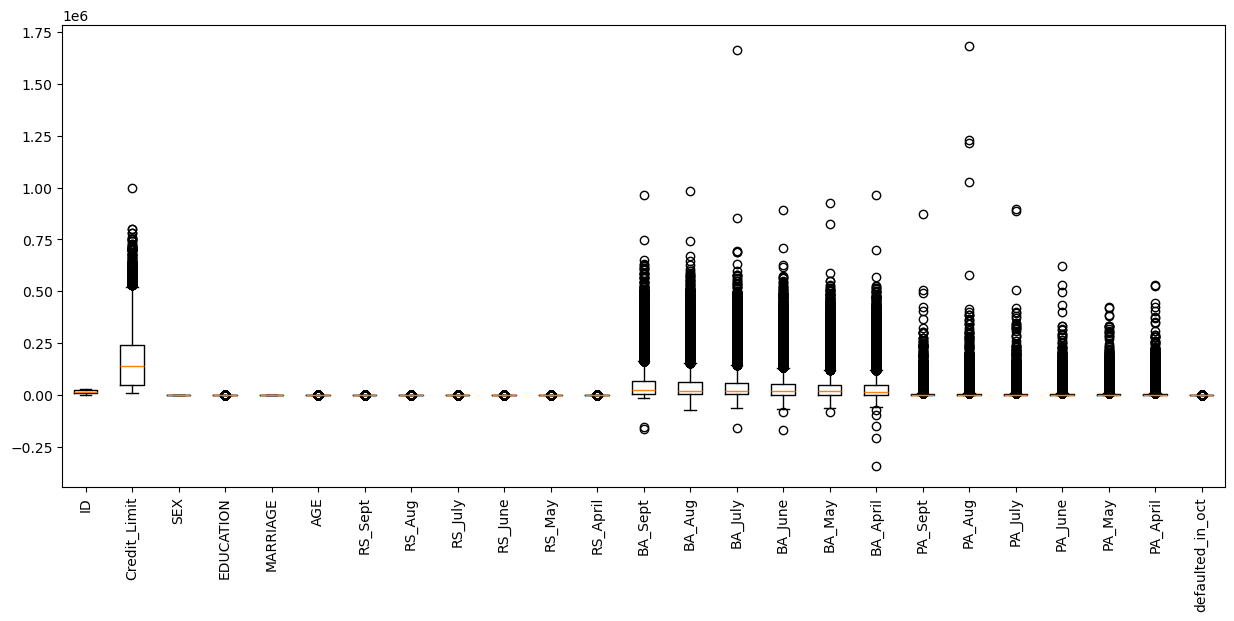

,Credit_Limit,RS_Sept,RS_Aug,RS_July,RS_June,RS_May,RS_April,BA_Sept,BA_Aug,BA_July,BA_June,BA_May,BA_April,PA_Sept,PA_Aug,PA_July,PA_June,PA_May,PA_April,defaulted_in_oct
5296,500000.0,-2,-2,-1,-1,-2,-1,125.0,-18088.0,1664089.0,121757.0,97115.0,377217.0,4366.0,1684259.0,121831.0,97670.0,379267.0,26759.0,0


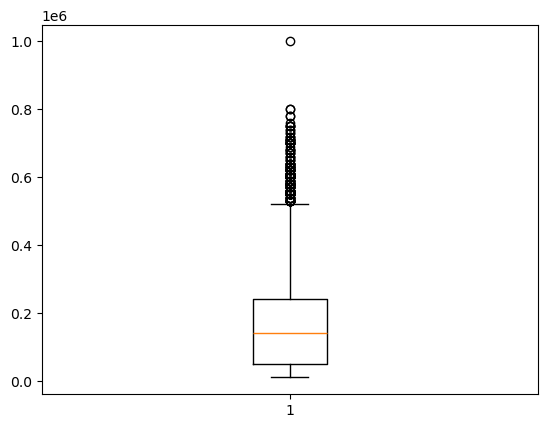

In [28]:
plt.figure(figsize=(15,6))
plt.boxplot(data,tick_labels=data.columns)
plt.xticks(rotation=90)
plt.show()

plt.boxplot(data['Credit_Limit'])
data.loc[[data["Credit_Limit"].idxmin()]].drop(columns=["ID","SEX","EDUCATION","MARRIAGE","AGE"])
#outlier investigated for Credit_Limit. Payments and bills match with clients credit limit.

data.loc[[data["BA_Sept"].idxmax()]].drop(columns=["ID","SEX","EDUCATION","MARRIAGE","AGE"])
#outlier investigated for BA_Sept (626k). After investigation its not a mistake, 
#the client has bill statements and pay statements all in that range which is why outliers across bill amounts and pay amounts consistently large.

data.loc[[data["PA_Aug"].idxmax()]].drop(columns=["ID","SEX","EDUCATION","MARRIAGE","AGE"])
#outlier investigated for BA_Aug (1.6 million). After investigation its not a mistake, the client had a bill amount of 1.6 million the month prior which explains PA_Aug strong outlier.


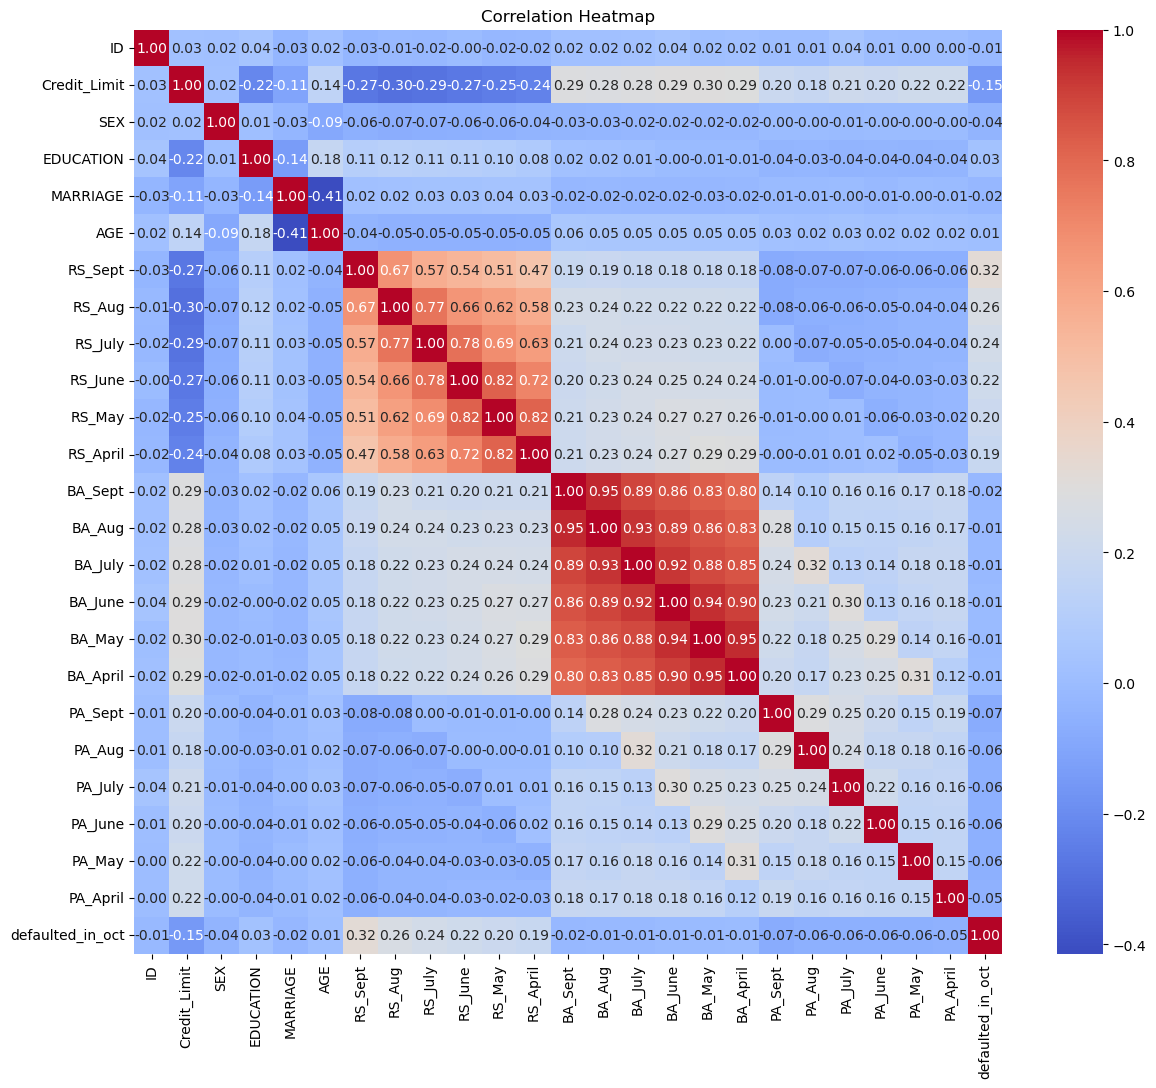

,ID,Credit_Limit,SEX,EDUCATION,MARRIAGE,AGE,RS_Sept,RS_Aug,RS_July,RS_June,...,BA_June,BA_May,BA_April,PA_Sept,PA_Aug,PA_July,PA_June,PA_May,PA_April,defaulted_in_oct
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000.0,1,3,1,39,0,0,0,0,...,88004.0,31237.0,15980.0,8500.0,20000.0,5003.0,3047.0,5000.0,1000.0,0
29996,29997,150000.0,1,3,2,43,-1,-1,-1,-1,...,8979.0,5190.0,0.0,1837.0,3526.0,8998.0,129.0,0.0,0.0,0
29997,29998,30000.0,1,2,2,37,4,3,2,-1,...,20878.0,20582.0,19357.0,0.0,0.0,22000.0,4200.0,2000.0,3100.0,1
29998,29999,80000.0,1,3,1,41,1,-1,0,0,...,52774.0,11855.0,48944.0,85900.0,3409.0,1178.0,1926.0,52964.0,1804.0,1


In [29]:
correlation_df = data.corr()
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_df, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

#Correlation Findings:
#Age and Marriage strongly negatively correlated: -41%
#Credit limit negatively correlated to repaymenet status:avg of -27%
#Credit limit possively correlated to bill and pay amount: avg of 29% for bill amount, 20% for pay amount
#Bill and pay amount negatively correlated to default: avg of -0.01% and -.06% repsectively
#all repayment status amongst the 6 months are correlated to eachother: more correlated the closer the months are to eachother (range 80%-50%)
#all bill amounts amongst the 6 months are correlated to eachother: more correlated the closer the months are to eachother (range 95%-80%)
data


Feature Selection


In [30]:
#columns to drop immediately/unneeded:
data = data.drop(columns=["ID"])

#Since repayment status and bill amounts are highly correlated within eachother and more correlated the closer the months, multicollinearity and redundency is a risk.
#To retain both short-term and long-term behaviour, I will keep the most recent month (Sept) for capturing short-term behaviour
#For long-term behaviour I will average the 6 months

data["RS_avg"] = data[["RS_Sept","RS_Aug","RS_July","RS_June","RS_May","RS_April"]].mean(axis=1)
data["BA_avg"] = data[["BA_Sept","BA_Aug","BA_July","BA_June","BA_May","BA_April"]].mean(axis=1)

#Add another aggregated column to list # of months out of 6 client has late payment
data["RS_late_count"] = (data[["RS_Sept","RS_Aug","RS_July","RS_June","RS_May","RS_April"]] > 0).sum(axis=1)

data=data.drop(columns=["RS_Aug","RS_July","RS_June","RS_May","RS_April"])
data=data.drop(columns=["BA_Aug","BA_July","BA_June","BA_May","BA_April"])


data


,Credit_Limit,SEX,EDUCATION,MARRIAGE,AGE,RS_Sept,BA_Sept,PA_Sept,PA_Aug,PA_July,PA_June,PA_May,PA_April,defaulted_in_oct,RS_avg,BA_avg,RS_late_count
0,20000.0,2,2,1,24,2,3913.0,0.0,689.0,0.0,0.0,0.0,0.0,1,-0.333333,1284.000000,2
1,120000.0,2,2,2,26,-1,2682.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1,0.500000,2846.166667,2
2,90000.0,2,2,2,34,0,29239.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0,0.000000,16942.166667,0
3,50000.0,2,2,1,37,0,46990.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0,0.000000,38555.666667,0
4,50000.0,1,2,1,57,-1,8617.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0,-0.333333,18223.166667,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,220000.0,1,3,1,39,0,188948.0,8500.0,20000.0,5003.0,3047.0,5000.0,1000.0,0,0.000000,120891.500000,0
29996,150000.0,1,3,2,43,-1,1683.0,1837.0,3526.0,8998.0,129.0,0.0,0.0,0,-0.666667,3530.333333,0
29997,30000.0,1,2,2,37,4,3565.0,0.0,0.0,22000.0,4200.0,2000.0,3100.0,1,1.333333,11749.333333,3
29998,80000.0,1,3,1,41,1,-1645.0,85900.0,3409.0,1178.0,1926.0,52964.0,1804.0,1,-0.166667,44435.166667,1


In [31]:
#Check correlation feature to target variables
data.corr()["defaulted_in_oct"]

#Results:
#Strongest features: RS_late_count (40%), RS_Sept (32%), RS_avg (28%), Credit_Limit (-15%)
#the more # of months a client misses there payment, the more likely they will default next month
#repayment history directly effects risk of next months repayment.
#credit limit has negative correlation because a higher credit limit would mean more trust client would pay on time

#Weakly correlated: PA -5%, demographics ±4%, BA -1%
#payment amount negatively correlated makes sense, higher payments is less late payments
#demographics minimal predictive power
#bill amounts minimal predictive power


Credit_Limit       -0.153520
SEX                -0.039961
EDUCATION           0.028006
MARRIAGE           -0.024339
AGE                 0.013890
RS_Sept             0.324794
BA_Sept            -0.019644
PA_Sept            -0.072929
PA_Aug             -0.058579
PA_July            -0.056250
PA_June            -0.056827
PA_May             -0.055124
PA_April           -0.053183
defaulted_in_oct    1.000000
RS_avg              0.281955
BA_avg             -0.012691
RS_late_count       0.398394
Name: defaulted_in_oct, dtype: float64

Feature Importance

In [32]:
#2 ways to check feature importance
#First) Random Forest Classifier: decides which features are most important for prediciton. Captures non-linear relationships and interactions between features
#Second) Logisitc Regression with L1: shows which features increase or decrease default risk. 
target = "defaulted_in_oct"
X = data.drop(columns=[target])
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 2: Random Forest (quick feature importance)
rf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight="balanced")
rf.fit(X_train, y_train)
rf_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Top Random Forest features:\n", rf_importances.head(10))

# Step 3: Logistic Regression (L1) for direction
#L1 penalty (Lasso reguralization) automatically selects the most important features by driving the coefficients of irrelevant ones to zero
logit = LogisticRegression(penalty="l1", solver="liblinear", class_weight="balanced", max_iter=1000)
logit.fit(X_train, y_train)
coefs = pd.Series(logit.coef_.ravel(), index=X.columns).sort_values(key=abs, ascending=False)
print("\nTop Logistic Regression features:\n", coefs.head(10))

#Random Forest: “Which features does the model use the most to make accurate predictions?” (importance only, no direction).
#Logistic Regression: “If this feature goes up, does risk go up or down?” (direction + strength).

#Results
#Random Forest Feature Importance:
#This will tell us which variables are most influential in determining defaulting
#random forest doesnt say if it increases or decreases default, just that it’s useful for splits.
#Top features are 1.bill amount average, 2.repayment status average, 3.bill amount september, 4.repayment status late count

#Logistic Regression Feature Importance:
#Positive coefficient → as the feature increases, the probability of default increases (higher risk).
#Negative coefficient → as the feature increases, the probability of default decreases (lower risk).
#Top features are: 1)repayment status late count, 2)repayment status average, 3)repayment status september, 4)sex
#repayment status late count: The more times someone paid late, the higher chance of default.
#repayment status average: A higher (better) average repayment status actually reduces the chance of default.
#repayment status september: a higher (better) repayment status in september has a lower chance of defaulting
#sex: men are coded as 1, women are coded as 2, a higher sex value has a lower chance of defaulting. Meaning women are more likely to pay on time

#Based on the results, the most important features for the model are RS_late_count, RS_avg, RS_Sept, BA_avg, and BA_Sept.
#Moderatly important features (still keeping them): PA_Sept, PA_Aug, PA_July, Credit_Limit, AGE
#Low importance features that will be dropped for dimensionality reduction: SEX, MARRIAGE, EDUCATION

data=data.drop(columns=["SEX","MARRIAGE","EDUCATION"])
data

Top Random Forest features:
 BA_avg           0.088986
RS_avg           0.085035
BA_Sept          0.083898
RS_late_count    0.078525
AGE              0.077745
Credit_Limit     0.074893
RS_Sept          0.071805
PA_Sept          0.070296
PA_Aug           0.068924
PA_July          0.066564
dtype: float64

Top Logistic Regression features:
 RS_late_count    0.576476
RS_avg          -0.463874
RS_Sept          0.339928
SEX             -0.147554
MARRIAGE        -0.112419
EDUCATION       -0.062783
AGE              0.005579
PA_Sept         -0.000007
PA_Aug          -0.000006
Credit_Limit    -0.000002
dtype: float64


,Credit_Limit,AGE,RS_Sept,BA_Sept,PA_Sept,PA_Aug,PA_July,PA_June,PA_May,PA_April,defaulted_in_oct,RS_avg,BA_avg,RS_late_count
0,20000.0,24,2,3913.0,0.0,689.0,0.0,0.0,0.0,0.0,1,-0.333333,1284.000000,2
1,120000.0,26,-1,2682.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1,0.500000,2846.166667,2
2,90000.0,34,0,29239.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0,0.000000,16942.166667,0
3,50000.0,37,0,46990.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0,0.000000,38555.666667,0
4,50000.0,57,-1,8617.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0,-0.333333,18223.166667,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,220000.0,39,0,188948.0,8500.0,20000.0,5003.0,3047.0,5000.0,1000.0,0,0.000000,120891.500000,0
29996,150000.0,43,-1,1683.0,1837.0,3526.0,8998.0,129.0,0.0,0.0,0,-0.666667,3530.333333,0
29997,30000.0,37,4,3565.0,0.0,0.0,22000.0,4200.0,2000.0,3100.0,1,1.333333,11749.333333,3
29998,80000.0,41,1,-1645.0,85900.0,3409.0,1178.0,1926.0,52964.0,1804.0,1,-0.166667,44435.166667,1


Model Training & Evaluation

Model Types and Descriptions:

1. Logistic Regression
A statistical model that predicts the probability of default (yes/no).
Works by finding a line (or boundary) that best separates defaulters from non-defaulters.
It’s simple, easy to interpret, and is being used as a baseline benchmark to give context to the other two models.

2. Random Forest
An ensemble method that builds many decision trees and combines their results.
Each tree makes a prediction, and the forest “votes” for the final outcome.
This reduces overfitting and usually improves accuracy compared to a single decision tree.


3. XGBoost (Extreme Gradient Boosting)
An advanced boosting algorithm that builds trees sequentially, with each new tree fixing errors made by the previous ones.
Very powerful for tabular data and often used in competitions and industry.
Typically gives the best performance but is more complex and resource-heavy.




Model Evaluator Descriptions
*Note* Its important to look at all evaluations to get the full picture

Accuracy: The percentage of all predictions the model got correct.
(True Positives + True Negatives) / Total Samples

Precision: The percentage of predicted defaulters that were actually defaulters. "Out of everyone I said would not pay me back, how many was didnt pay?"
True Positives / (True Positives + False Positives)

Recall: The percentage of actual defaulters the model successfully identified. "Out of all the real defaulters, how many did I find?"
True Positives / (True Positives + False Negatives)

F1: A single number that balances precision and recall.
2 * (Precision * Recall) / (Precision + Recall)

ROC-AUC: A measure of how well the model separates defaulters from non-defaulters overall 
(0.5 = random, 1.0 = perfect)

*Note* pos_label=1 in recall_score(y_test, y_pred, pos_label=1) indicates assigning the value 1 to be the risky outcome were trying to predict. In this case it would be predicting defaulters. The metric automatically assigns the pos_label to the highest value (1 in this case as we have 1 and 0 inputs) but its good practice to assign and not rely on metric defaults.

In [34]:
# 1. Split data
X = data.drop(columns=["defaulted_in_oct"])   # features
y = data["defaulted_in_oct"]                  # target

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 2. Train Logistic Regression
log_reg = LogisticRegression(max_iter=1000, solver='lbfgs')
log_reg.fit(X_train, y_train)

# 3. Train Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# 4. Train XGBoost
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42
)
xgb_model.fit(X_train, y_train)

# 5. Predictions
y_pred_lr = log_reg.predict(X_test)
y_pred_rf = rf.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)

# 6. Evaluation function
def evaluate_model(y_test, y_pred, model_name):
    print(f"\n{model_name}:")
    print(f"Accuracy:, {accuracy_score(y_test, y_pred)*100:.2f}%")
    print(f"Precision:, {precision_score(y_test, y_pred, pos_label=1)*100:.2f}%")
    print(f"Recall:, {recall_score(y_test, y_pred, pos_label=1)*100:.2f}%")
    print(f"F1:, {f1_score(y_test, y_pred, pos_label=1)*100:.2f}%")

# 7. Evaluate models
evaluate_model(y_test, y_pred_lr, "Logistic Regression")
evaluate_model(y_test, y_pred_rf, "Random Forest")
evaluate_model(y_test, y_pred_xgb, "XGBoost")

# 8. ROC-AUC
print(f"\nROC-AUC Logistic:, {roc_auc_score(y_test, log_reg.predict_proba(X_test)[:,1])*100:.2f}%")
print(f"ROC-AUC Random Forest:, {roc_auc_score(y_test, rf.predict_proba(X_test)[:,1])*100:.2f}%")
print(f"ROC-AUC XGBoost:, {roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:,1])*100:.2f}%")


# -------------------------------
# Model Results Analysis
# -------------------------------
# - Logistic Regression: simple and easy to interpret, but misses many defaulters (low recall).
# - Random Forest: better at catching defaulters and has improved balance between precision and recall.
# - XGBoost: best overall model, strong accuracy and ROC-AUC, but recall could still be improved

# Next Step:
# Models have decent performance however not good enough to deliver. Banks typically prioritize recall so more work can be done to improve recall.
# Accuracy at 82% can be misleading due to the imbalanced credit risk dataset.
# Hyperparameter tuning for Random Forest and XGBoost can improve recall, F1-score, and ROC-AUC by finding the best settings for each model.



Logistic Regression:
Accuracy:, 81.03%
Precision:, 66.21%
Recall:, 29.09%
F1:, 40.42%

Random Forest:
Accuracy:, 81.27%
Precision:, 63.23%
Recall:, 36.55%
F1:, 46.32%

XGBoost:
Accuracy:, 82.00%
Precision:, 67.03%
Recall:, 36.62%
F1:, 47.37%

ROC-AUC Logistic:, 73.77%
ROC-AUC Random Forest:, 74.71%
ROC-AUC XGBoost:, 77.01%


Hypertuning Models

Why we hypertune models:
Random forest and XGBoost are tree-based models. They have parameters that can be tweaked such as how many trees are used, how deep the trees grow, and how sensitive the model is to noise.

If theses parameters are left alone and not set to a specific value the model risks overfitting (memorizing training data rather than learning generalizable underlying patterns.) or underfitting (too simple and skips over important patterns)

Tuning these parameters hopefully will improve performance on unseen data (test data)

Referencing these official models websites for determining hypertuning ranges:
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#
https://xgboost.readthedocs.io/en/stable/parameter.html

After selecting hyperparameter tuning ranges, use GridSearchCV to test all hypertuning possibilities as selected (rf_params, xgb_params). It utilizes cross-validation to test all combinations and evaluates it finding the best fit for the model and train data. The best fit is measured by assigning scoring to recall evaluation as it is most important in credit risk predictions. When running GridSearchCV I include a parameter "cv=3" which allows the training data to be split into 3 equal folds. For each hyperparameter combination, the model is trained and tested 3 times, rotating which fold is used for validation, and the performance is averaged across the runs. This prevents the model from getting lucky on one split and gives a more reliable estimate of how the hyperparameters will perform on new data.

In [35]:
# Helper function to evaluate model
def evaluate_model(model, X_test, y_test, model_name="Model"):
    y_pred = model.predict(X_test)
    print(f"\n{model_name}: ")
    print(f"Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%")
    print(f"Precision: {precision_score(y_test, y_pred, pos_label=1)*100:.2f}%")
    print(f"Recall: {recall_score(y_test, y_pred, pos_label=1)*100:.2f}%")
    print(f"F1: {f1_score(y_test, y_pred, pos_label=1)*100:.2f}%")
    print(f"ROC-AUC: {roc_auc_score(y_test, y_pred)*100:.2f}%")

# Random Forest

# Baseline
rf_base = RandomForestClassifier(random_state=42)
rf_base.fit(X_train, y_train)

# Hyperparameter Tuning
rf_params = {
    "n_estimators": [100, 200],
    "max_depth": [5, 10, None],
    "min_samples_split": [2, 5, 10],
    "class_weight": [None, "balanced"]
}
#Testing all hypertuning possibilities given in the rf_params 
rf_grid = GridSearchCV(rf_base, rf_params, cv=3, scoring="recall", n_jobs=-1)
rf_grid.fit(X_train, y_train)

# Evaluate both
evaluate_model(rf_base, X_test, y_test, "Random Forest (Baseline)")
evaluate_model(rf_grid.best_estimator_, X_test, y_test, "Random Forest (Tuned)")


#XGBoost

# Baseline
xgb_base = XGBClassifier(eval_metric="logloss", random_state=42)
xgb_base.fit(X_train, y_train)

# Hyperparameter tuning
xgb_params = {
    "n_estimators": [100, 200],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.2],
    "subsample": [0.8, 1],
    "scale_pos_weight": [1, 2, 5]
}
#Testing all hypertuning possibilities given in the xgb_grid
xgb_grid = GridSearchCV(xgb_base, xgb_params, cv=3, scoring="recall", n_jobs=-1)
xgb_grid.fit(X_train, y_train)

# Evaluate both
evaluate_model(xgb_base, X_test, y_test, "XGBoost (Baseline)")
evaluate_model(xgb_grid.best_estimator_, X_test, y_test, "XGBoost (Tuned)")



Random Forest (Baseline): 
Accuracy: 81.27%
Precision: 63.23%
Recall: 36.55%
F1: 46.32%
ROC-AUC: 65.26%

Random Forest (Tuned): 
Accuracy: 74.55%
Precision: 44.59%
Recall: 62.17%
F1: 51.94%
ROC-AUC: 70.12%

XGBoost (Baseline): 
Accuracy: 80.98%
Precision: 61.89%
Recall: 36.47%
F1: 45.90%
ROC-AUC: 65.05%

XGBoost (Tuned): 
Accuracy: 60.73%
Precision: 33.58%
Recall: 79.28%
F1: 47.17%
ROC-AUC: 67.37%


Results

Random Forest:
The baseline Random Forest model achieved good overall accuracy (81.27%) but struggled with recall (36.55%), meaning it often missed catching defaulted cases (caught approx. a third of defaulters). After hyperparameter tuning, accuracy dropped (74.55%), but recall improved significantly (62.17%), showing the tuned model became better at identifying defaulters, even at the cost of more false positives.

XGBoost:
The baseline XGBoost model performed similarly to the baseline Random Forest, with good overall accuracy (80.98%) and poor recall (36.47%). However, after tuning, recall improved drastically (79.28%), though accuracy decreased (60.73%), indicating the model was more aggressive in predicting defaulters.

Overall, tuning both models traded accuracy for recall, which is valuable when the main goal is to catch as many defaulters as possible. This is more ideal because as a bank theyre more focused on predicting those clients that will default. XGBoost (Tuned) is the best model and I will proceed with this one

Test Model on Example Clients:

Im testing 3 seperate client cases, the point here isn’t to train or evaluate the model, it’s just to see how the model predicts on new data.

In [36]:
# Save the tuned XGBoost model
joblib.dump(xgb_grid.best_estimator_, "xgb_tuned_model.pkl")
# Load the model back
loaded_model = joblib.load("xgb_tuned_model.pkl")


In [37]:
# Example realistic clients
new_clients = pd.DataFrame([
    {
        "Credit_Limit": 430000,
        "AGE": 35,
        "RS_Sept": -1,  # always paid in full last month
        "BA_Sept": 15000,
        "PA_Sept": 15000,
        "PA_Aug": 12000,
        "PA_July": 14000,
        "PA_June": 13000,
        "PA_May": 10000,
        "PA_April": 11000,
        "RS_avg": -0.5,  # mostly paid on time
        "BA_avg": 13000,
        "RS_late_count": 0
    },
    {
        "Credit_Limit": 200000,
        "AGE": 42,
        "RS_Sept": 1,  # 1 month late
        "BA_Sept": 25000,
        "PA_Sept": 10000,
        "PA_Aug": 5000,
        "PA_July": 8000,
        "PA_June": 9000,
        "PA_May": 0,
        "PA_April": 12000,
        "RS_avg": 0.8,  # some months late
        "BA_avg": 17000,
        "RS_late_count": 3
    },
    {
        "Credit_Limit": 100000,
        "AGE": 28,
        "RS_Sept": 3,  # 3 months late
        "BA_Sept": 50000,
        "PA_Sept": 10000,
        "PA_Aug": 0,
        "PA_July": 5000,
        "PA_June": 0,
        "PA_May": 0,
        "PA_April": 0,
        "RS_avg": 2.0,  # mostly late
        "BA_avg": 10000,
        "RS_late_count": 5
    }
])

print(new_clients)


   Credit_Limit  AGE  RS_Sept  BA_Sept  PA_Sept  PA_Aug  PA_July  PA_June  \
0        430000   35       -1    15000    15000   12000    14000    13000   
1        200000   42        1    25000    10000    5000     8000     9000   
2        100000   28        3    50000    10000       0     5000        0   

   PA_May  PA_April  RS_avg  BA_avg  RS_late_count  
0   10000     11000    -0.5   13000              0  
1       0     12000     0.8   17000              3  
2       0         0     2.0   10000              5  


In [57]:
# 1) Get the tuned XGBoost estimator
best_xgb = xgb_grid.best_estimator_

# 2) Lock the feature order to the one the model was trained on (if available), else use your list
try:
    feature_cols = list(best_xgb.feature_names_in_)
except AttributeError:
    feature_cols = ['Credit_Limit', 'AGE', 'RS_Sept','BA_Sept','PA_Sept', 'PA_Aug', 'PA_July', 'PA_June', 'PA_May', 'PA_April','RS_avg', 'BA_avg', 'RS_late_count']

# 3) Build a features-only view (don’t pass extra columns to the model)
X_new = new_clients.loc[:, feature_cols].copy()

# 4) Make a copy to store predictions (keeps your original new_clients intact)
new_clients_results = new_clients.copy()

# 5) Predict class and probability
new_clients_results['Predicted_Default'] = best_xgb.predict(X_new)
new_clients_results['Default_Probability_%'] = best_xgb.predict_proba(X_new)[:, 1]
#Convert Default_Probability_% to be viewed in correct for (convert decimal to percent value, rounded, add %)
new_clients_results['Default_Probability_%'] = (new_clients_results['Default_Probability_%']*100).round(2).astype(str) + '%'

# 6) Show all input features + predictions (this prints actual client data)
cols_to_show = ['Predicted_Default','Default_Probability_%'] + feature_cols
new_clients_results[cols_to_show]


,Predicted_Default,Default_Probability_%,Credit_Limit,AGE,RS_Sept,BA_Sept,PA_Sept,PA_Aug,PA_July,PA_June,PA_May,PA_April,RS_avg,BA_avg,RS_late_count
0,0,39.82%,430000,35,-1,15000,15000,12000,14000,13000,10000,11000,-0.5,13000,0
1,1,70.74%,200000,42,1,25000,10000,5000,8000,9000,0,12000,0.8,17000,3
2,1,80.14%,100000,28,3,50000,10000,0,5000,0,0,0,2.0,10000,5


Results:
The XGBoost tuned model predicts that client 0 is unlikely to default, with a 39.82% probability, while clients 1 and 2 are predicted as high risk, with probability defaulting at 70.74% and 80.14%, respectively. This is an example of how the model would be applied in real time use case.

In summary, this project built, evaluated, and hyper-tuned machine learning models to predict credit default risk. XGBoost with hyperparameter tuning achieved the best performance, particularly in capturing high-risk clients. This project demonstrates how such a model could be applied to support informed credit decisions, helping to identify clients at higher risk of default while minimizing unnecessary restrictions on low-risk clients.